# Demonstrate MCMC exploration of posterior distribution of conic parameters

## Imports

We need to explictly add the path to the library since we haven't installed it yet.

In [1]:
import time

In [2]:
start_time = time.time()
from pathlib import Path

In [3]:
import confitti
import numpy as np
import lmfit
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
sns.set_context("notebook", font_scale=1.2)

In [5]:
figpath = Path.cwd().parent / "figs"
saveprefix = "demo02"

## Test data

Symmetric arrangement of 7 points, which I then stretch and distort to make it more interesting.  Using fewer than 7 points is not recommended, although it is possible to get spectacularly small residuals that way!

In [6]:
xpts, ypts = np.array([1, 2, 3, 4, 5, 6, 7]), np.array([0, 4, 6, 7, 6, 4, 0])
ypts += xpts
xpts *= 3

## Do the fitting

Fit of parabola and a general conic, as in demo01

In [7]:
result_p = confitti.fit_conic_to_xy(xpts, ypts, only_parabola=True)
result_e = confitti.fit_conic_to_xy(xpts, ypts, only_parabola=False)

First look at the general curve.

In [8]:
result_e


There are some significant correlations between parameters, which can be better studied via MCMC, which we will do next

## Calculate posterior probability of parameters with emcee



In [9]:
emcee_kws = dict(
    steps=1000,
    burn=300,
    thin=20,
    is_weighted=False,
    progress=False,
    workers=16,
    nan_policy="omit",
)
emcee_params = result_e.params.copy()

In [10]:
result_emcee = lmfit.minimize(
    confitti.residual,
    args=(xpts, ypts),
    method="emcee",
    params=emcee_params,
    **emcee_kws,
)

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 99.3375875   99.1568968   88.70806607 102.73271912  82.85519271
 103.73667645]


In [11]:
result_emcee

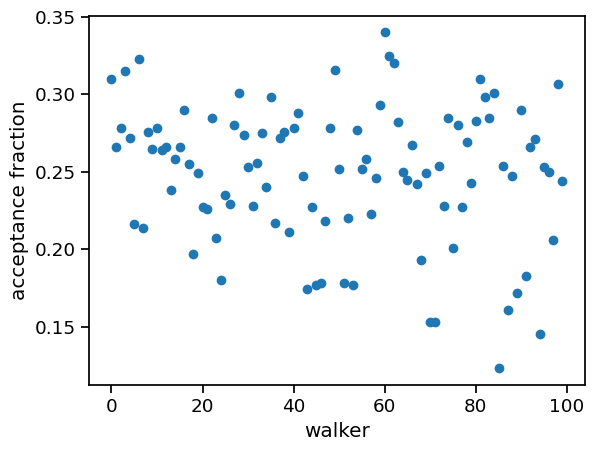

In [12]:
plt.plot(result_emcee.acceptance_fraction, "o")
plt.xlabel("walker")
plt.ylabel("acceptance fraction")
plt.show()

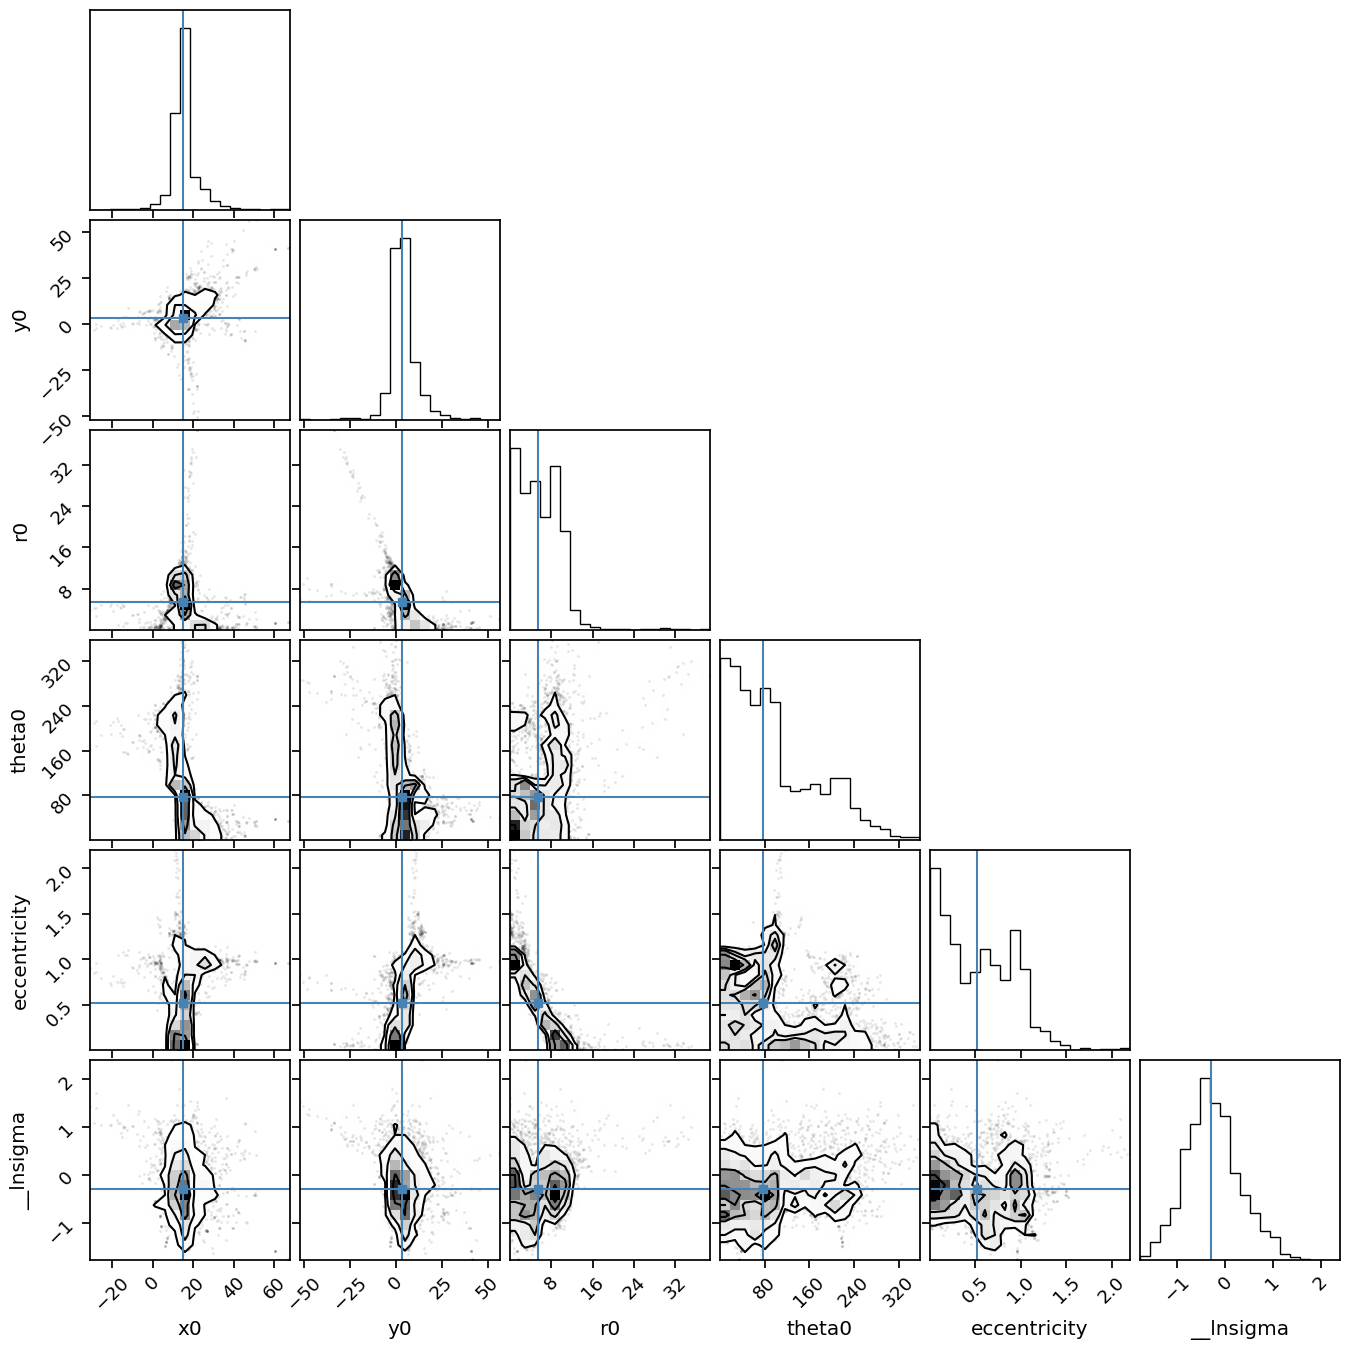

In [13]:
import corner

emcee_plot = corner.corner(
    result_emcee.flatchain,
    labels=result_emcee.var_names,
    truths=list(result_emcee.params.valuesdict().values()),
)

In [14]:
emcee_plot.savefig(figpath / f"{saveprefix}-corner-e.pdf", bbox_inches="tight")

In [15]:
result_emcee_p = lmfit.minimize(
    confitti.residual,
    args=(xpts, ypts),
    method="emcee",
    params=result_p.params.copy(),
    **emcee_kws,
)

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [119.00960702 116.89656103  89.46254072  90.69957075 133.20460941]


In [16]:
result_emcee_p

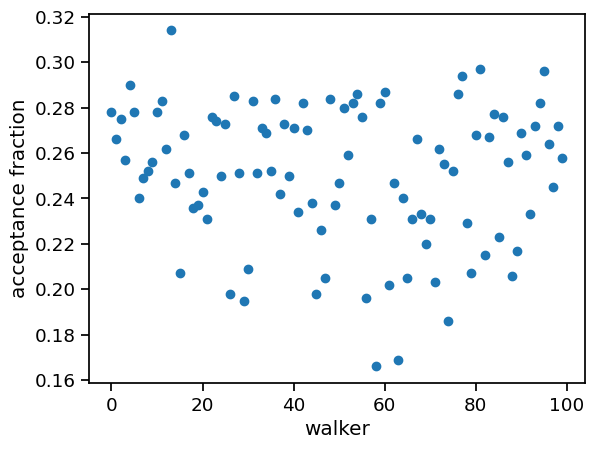

In [17]:
plt.plot(result_emcee_p.acceptance_fraction, "o")
plt.xlabel("walker")
plt.ylabel("acceptance fraction")
plt.show()

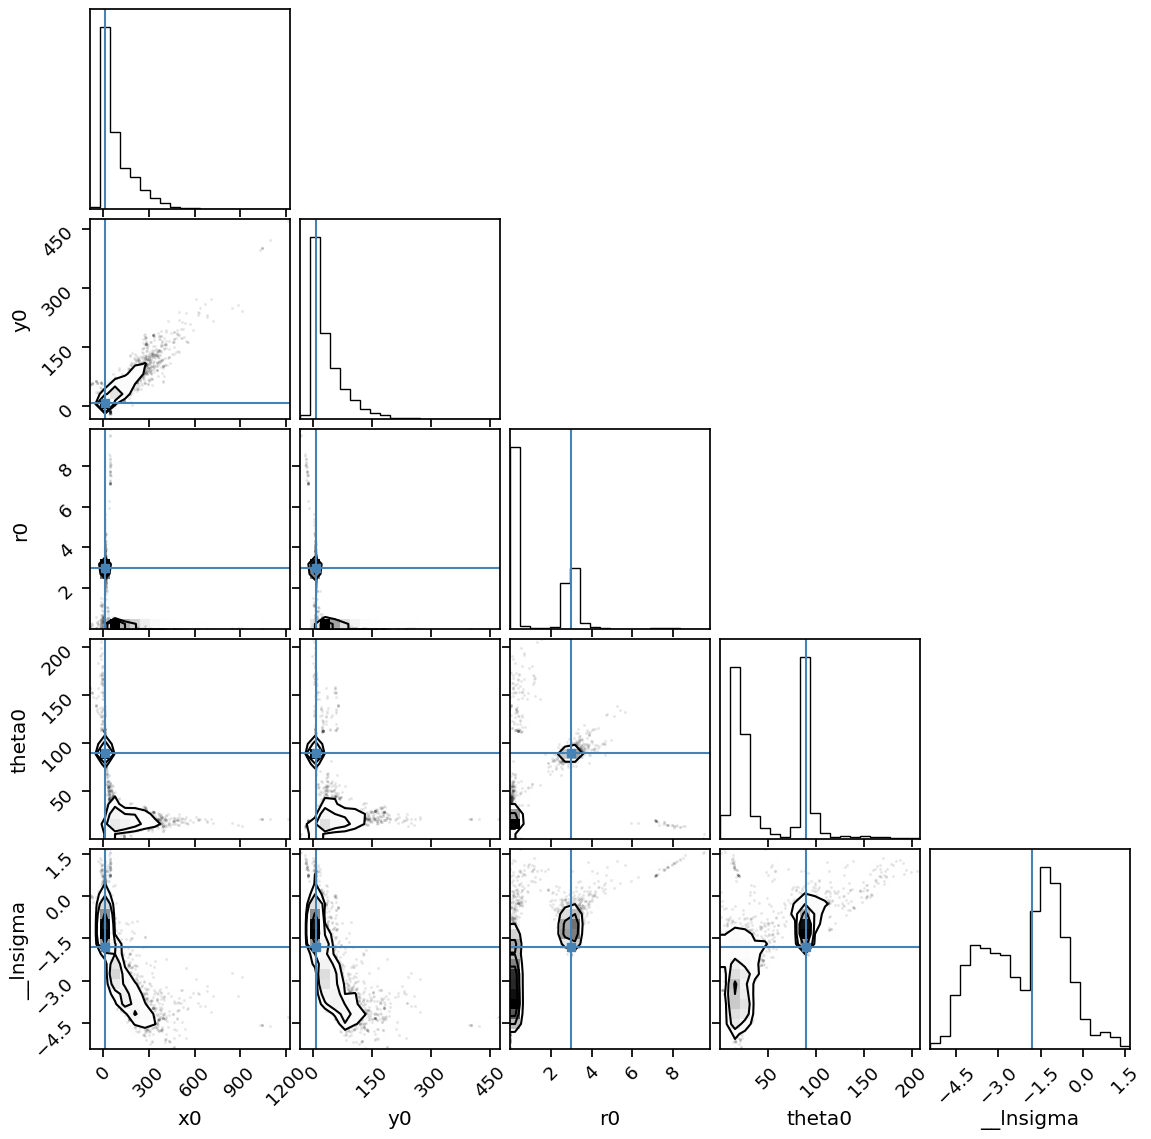

In [18]:
# truths = [result_emcee_p.params.valuesdict()[name] for name in result_emcee_p.var_names]
truths = [result_p.params.valuesdict()[name] for name in result_p.var_names] + [
    result_emcee_p.params.valuesdict()["__lnsigma"]
]
emcee_plot_p = corner.corner(
    result_emcee_p.flatchain,
    labels=result_emcee_p.var_names,
    truths=truths,
)

In [19]:
emcee_plot_p.savefig(figpath / f"{saveprefix}-corner-p.pdf", bbox_inches="tight")

## Plotting the best fit onto the data

In [20]:
best_xy = confitti.XYconic(**result_p.params.valuesdict())
print(best_xy)

Conic section curve with focus at (13.9604320891964, 8.23028636315502), scale factor 2.982708818864563, angle 90.18600565514018, and eccentricity 1.0.


/Users/will/Dropbox/confitti/src/confitti/confitti.py:131: RuntimeWarning: divide by zero encountered in divide
  self.r0


Get a list of dicts with the conic parameters from the MC chain

In [21]:
chain_pars = result_emcee_p.flatchain.drop(columns="__lnsigma").to_dict(
    orient="records"
)
len(chain_pars)

3500

Take every 10th row so we have 350 samples in total and get the xy curves for them all

In [22]:
chain_xy = [confitti.XYconic(**row, eccentricity=1.0) for row in chain_pars[3::10]]

/Users/will/Dropbox/confitti/src/confitti/confitti.py:131: RuntimeWarning: divide by zero encountered in divide
  self.r0


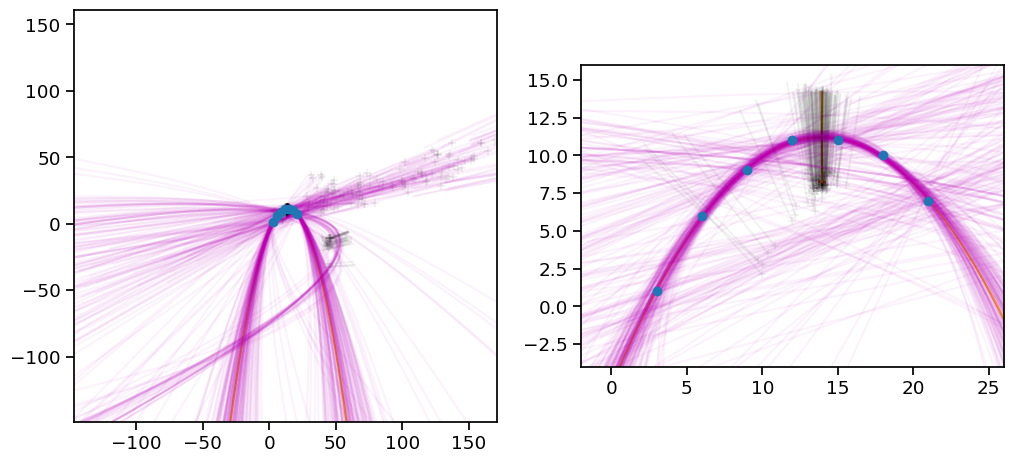

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
for ax in axes:
    ax.scatter(xpts, ypts, zorder=1000)

    c = "orange"
    ax.plot(best_xy.x_pts, best_xy.y_pts, color=c)
    ax.scatter(best_xy.x0, best_xy.y0, marker="+", color=c)
    ax.plot([best_xy.x0, best_xy.x_mirror], [best_xy.y0, best_xy.y_mirror], color=c)

    c = "m"
    alpha = 0.05
    for xy in chain_xy:
        ax.plot(xy.x_pts, xy.y_pts, color=c, alpha=alpha)
        ax.scatter(xy.x0, xy.y0, marker="+", color="k", alpha=alpha)
        ax.plot([xy.x0, xy.x_mirror], [xy.y0, xy.y_mirror], color="k", alpha=alpha)

    ax.set_aspect("equal")
margin = 150
axes[0].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
margin = 5
axes[1].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
...;

In [24]:
fig.savefig(figpath / f"{saveprefix}-emcee-samples-p.pdf", bbox_inches="tight")

In [25]:
best_xy = confitti.XYconic(**result_e.params.valuesdict())
chain_pars = result_emcee.flatchain.drop(columns="__lnsigma").to_dict(orient="records")
chain_xy = [confitti.XYconic(**row) for row in chain_pars[1::10]]

/Users/will/Dropbox/confitti/src/confitti/confitti.py:131: RuntimeWarning: divide by zero encountered in divide
  self.r0


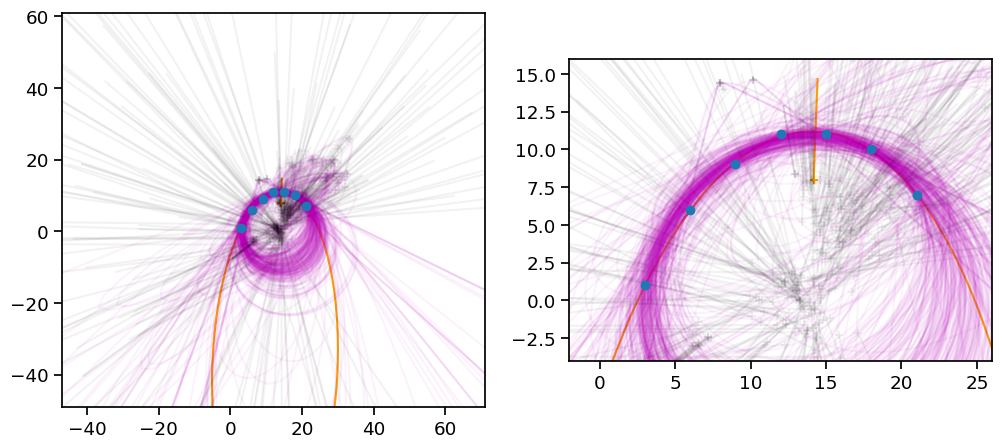

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
for ax in axes:
    ax.scatter(xpts, ypts, zorder=1000)
    c = "orange"
    ax.plot(best_xy.x_pts, best_xy.y_pts, color=c)
    ax.scatter(best_xy.x0, best_xy.y0, marker="+", color=c)
    ax.plot([best_xy.x0, best_xy.x_mirror], [best_xy.y0, best_xy.y_mirror], color=c)

    c = "m"
    alpha = 0.05
    for xy in chain_xy:
        ax.plot(xy.x_pts, xy.y_pts, color=c, alpha=alpha)
        ax.scatter(xy.x0, xy.y0, marker="+", color="k", alpha=alpha)
        ax.plot([xy.x0, xy.x_mirror], [xy.y0, xy.y_mirror], color="k", alpha=alpha)
    ax.set_aspect("equal")

margin = 50
axes[0].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
margin = 5
axes[1].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
...;

In [27]:
fig.savefig(figpath / f"{saveprefix}-emcee-samples-e.pdf", bbox_inches="tight")

## Try and put limits on parameters to avoid the "unreasonable" global minima

### Getting rid of the long narrow parabolae

In the parabola case, we have a whole bunch of supposedly valid fits that have small value of `r0` (less than 1) coupled with large values of `x0` and `y0` (more than 30) and `theta0` angles around 30 deg. In the figure above, they can be seen to all be well separated from the "good" fits.  So if we put bounds on `r0` we could possibly eliminate them.

Also, the first time I tried this, it found a whole bunch of garbage solutions, for which the estimate of `__lnsigma` was large, where `__lnsigma` is an extra parameter that gets automatically added by emcee that holds an estimate of the data point uncertainty. Of course, if this is large then any model would fit and so the results are meaningless. We can fix this by explicitly adding the parameter ourselves and putting an upper bound on it.

In [28]:
new_params = result_p.params.copy()
rscale = new_params["r0"].value
new_params["r0"].set(min=rscale / 2, max=rscale * 2)
new_params.add("__lnsigma", value=np.log(0.1), min=np.log(0.001), max=np.log(1))
new_params

name,value,standard error,relative error,initial value,min,max,vary
x0,13.9604321,0.31535693,(2.26%),12.0,-inf,inf,True
y0,8.23028636,0.21719264,(2.64%),7.857142857142857,-inf,inf,True
r0,2.98270882,0.15103889,(5.06%),4.670003423475774,1.49135441,5.96541764,True
theta0,90.1860057,2.64712924,(2.94%),96.9268304461369,0.00000000,360.000000,True
eccentricity,1.00000000,0.00000000,(0.00%),1.0,0.00000000,inf,False
__lnsigma,-2.30258509,,,-2.3025850929940455,-6.90775528,0.00000000,True


We got a complaint about the chains being too short, so I have increased to 5000

In [29]:
long_emcee_kws = emcee_kws | dict(steps=5000, burn=1000)
long_emcee_kws

{'steps': 5000,
 'burn': 1000,
 'thin': 20,
 'is_weighted': False,
 'progress': False,
 'workers': 16,
 'nan_policy': 'omit'}

In [30]:
result_emcee_pp = lmfit.minimize(
    confitti.residual,
    args=(xpts, ypts),
    method="emcee",
    params=new_params,
    **long_emcee_kws,
)

In [31]:
result_emcee_pp

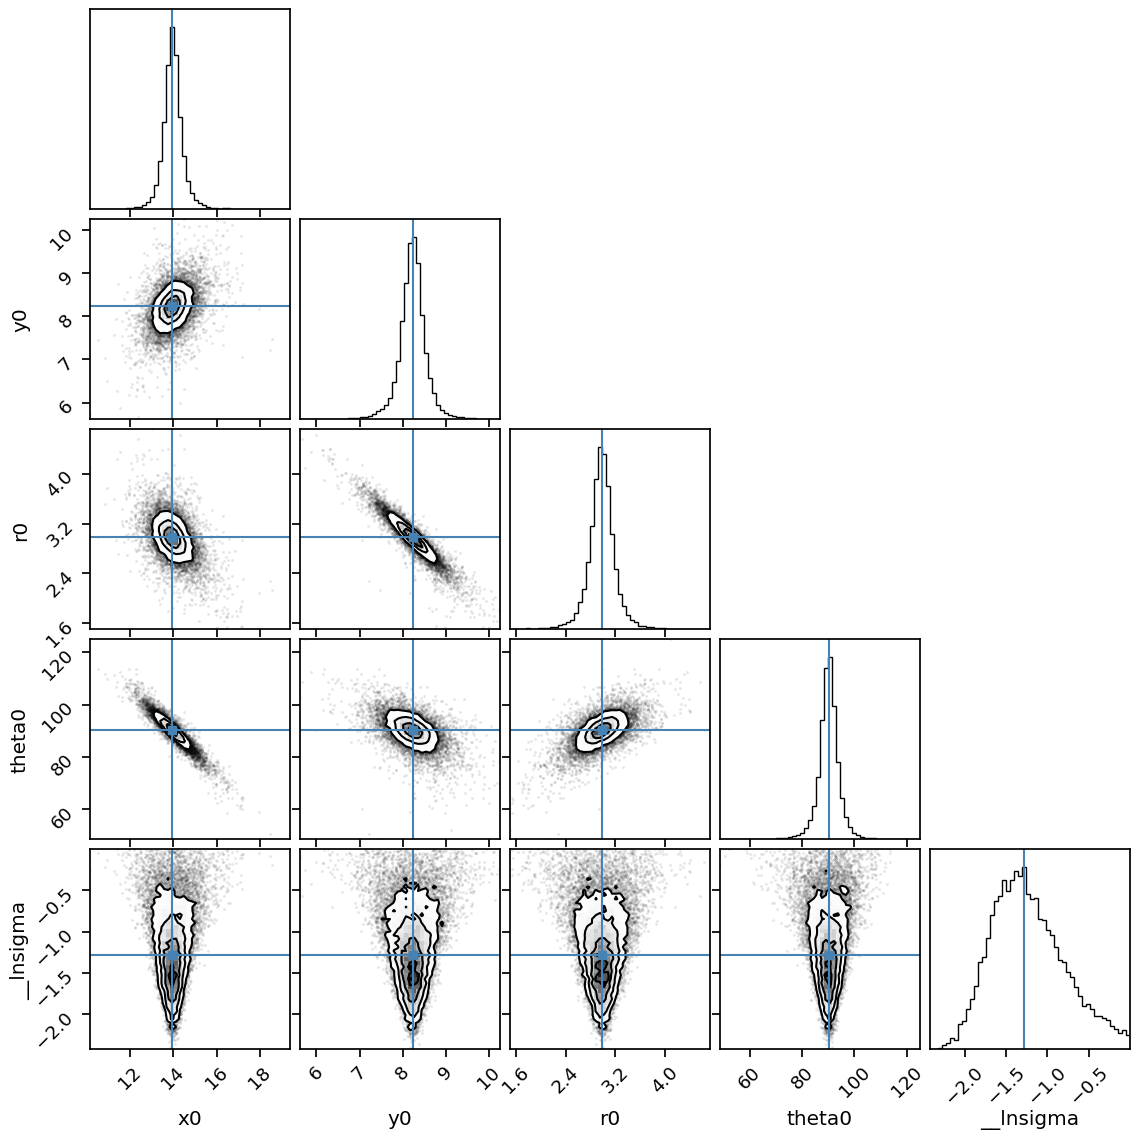

In [32]:
truths = [
    result_emcee_pp.params.valuesdict()[name] for name in result_emcee_pp.var_names
]
emcee_plot_p = corner.corner(
    result_emcee_pp.flatchain,
    labels=result_emcee_pp.var_names,
    truths=truths,
    bins=50,
)

In [33]:
emcee_plot_p.savefig(
    figpath / f"{saveprefix}-corner-p-improved.pdf", bbox_inches="tight"
)

Finally, we have a nice-looking corner plot with elliptical contours!

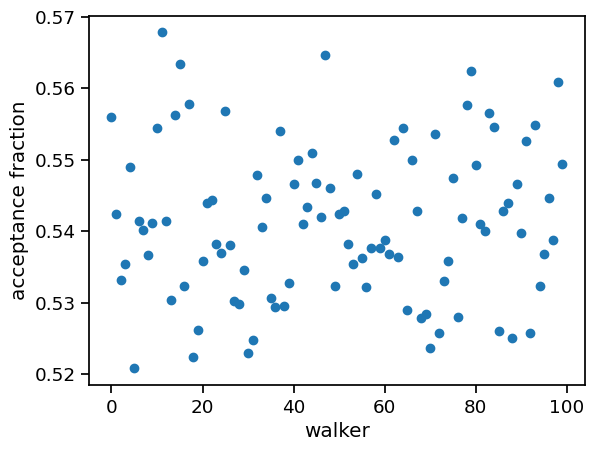

In [34]:
plt.plot(result_emcee_pp.acceptance_fraction, "o")
plt.xlabel("walker")
plt.ylabel("acceptance fraction")
plt.show()

And the acceptance fraction looks fine.

In [35]:
len(result_emcee_pp.flatchain)

20000

Now that we have a longer chain, we have to be careful not to take too many samples for the plot, so take every 100th, which should give 200 samples

In [36]:
best_xy = confitti.XYconic(**result_p.params.valuesdict())
chain_pars = result_emcee_pp.flatchain.drop(columns="__lnsigma").to_dict(
    orient="records"
)
chain_xy = [confitti.XYconic(**row, eccentricity=1.0) for row in chain_pars[1::100]]

/Users/will/Dropbox/confitti/src/confitti/confitti.py:131: RuntimeWarning: divide by zero encountered in divide
  self.r0
/Users/will/Dropbox/confitti/src/confitti/confitti.py:131: RuntimeWarning: divide by zero encountered in divide
  self.r0


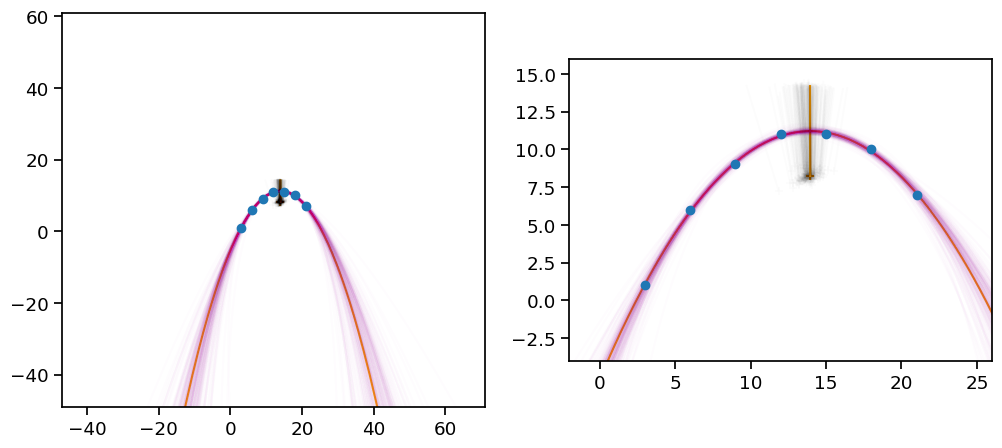

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
for ax in axes:
    c = "orange"
    ax.plot(best_xy.x_pts, best_xy.y_pts, color=c)
    ax.scatter(best_xy.x0, best_xy.y0, marker="+", color=c)
    ax.plot([best_xy.x0, best_xy.x_mirror], [best_xy.y0, best_xy.y_mirror], color=c)

    c = "m"
    alpha = 0.01
    for xy in chain_xy:
        ax.plot(xy.x_pts, xy.y_pts, color=c, alpha=alpha)
        ax.scatter(xy.x0, xy.y0, marker="+", color="k", alpha=alpha)
        ax.plot([xy.x0, xy.x_mirror], [xy.y0, xy.y_mirror], color="k", alpha=alpha)
    ax.scatter(xpts, ypts, zorder=1000)
    ax.set_aspect("equal")

margin = 50
axes[0].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
margin = 5
axes[1].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
...;

In [38]:
fig.savefig(figpath / f"{saveprefix}-emcee-samples-p-improved.pdf", bbox_inches="tight")

So now we have a nice clean set of parabola fits. We can see visually the correlation between `x0` and `theta0`: as the focus moves left or right, the parabola axis has to swing around to accomodate the data points. Similarly, the correlation between `y0` and `r0` is due to the vertical orientation of the axis.

### Pruning the diversity of conic solutions

In the good parabola fits, we find `__lnsigma = -1.5` approx, which is $\sigma \approx 0.2$. This is also the same order as the residuals to the best fit, which we saw in demo01.  Therefore, we should probably be rejecting any fits that require a much larger uncertainty in the data points. From the histogram in the corner plot above, it looks like `__lnsigma < -0.5` is a reasonable choice.

In [39]:
new_params = result_e.params.copy()
rscale = new_params["r0"].value
new_params["r0"].set(min=rscale / 3, max=rscale * 3)
new_params.add("__lnsigma", value=np.log(0.1), min=np.log(0.001), max=-0.8)
new_params

name,value,standard error,relative error,initial value,min,max,vary
x0,14.1836937,0.62239153,(4.39%),12.0,-inf,inf,True
y0,7.94428397,0.70230734,(8.84%),7.857142857142857,-inf,inf,True
r0,3.24220033,0.61614891,(19.00%),4.670003423475774,1.08073344,9.72660098,True
theta0,87.8025893,6.56714723,(7.48%),96.9268304461369,0.00000000,360.000000,True
eccentricity,0.93362537,0.14810892,(15.86%),1.0,0.00000000,inf,True
__lnsigma,-2.30258509,,,-2.3025850929940455,-6.90775528,-0.80000000,True


In [40]:
result_emcee_ee = lmfit.minimize(
    confitti.residual,
    args=(xpts, ypts),
    method="emcee",
    params=new_params,
    **long_emcee_kws,
)

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [323.76805544 275.12809312 196.00710797 347.00052182 277.70245623
 169.01855521]


In [41]:
result_emcee_ee

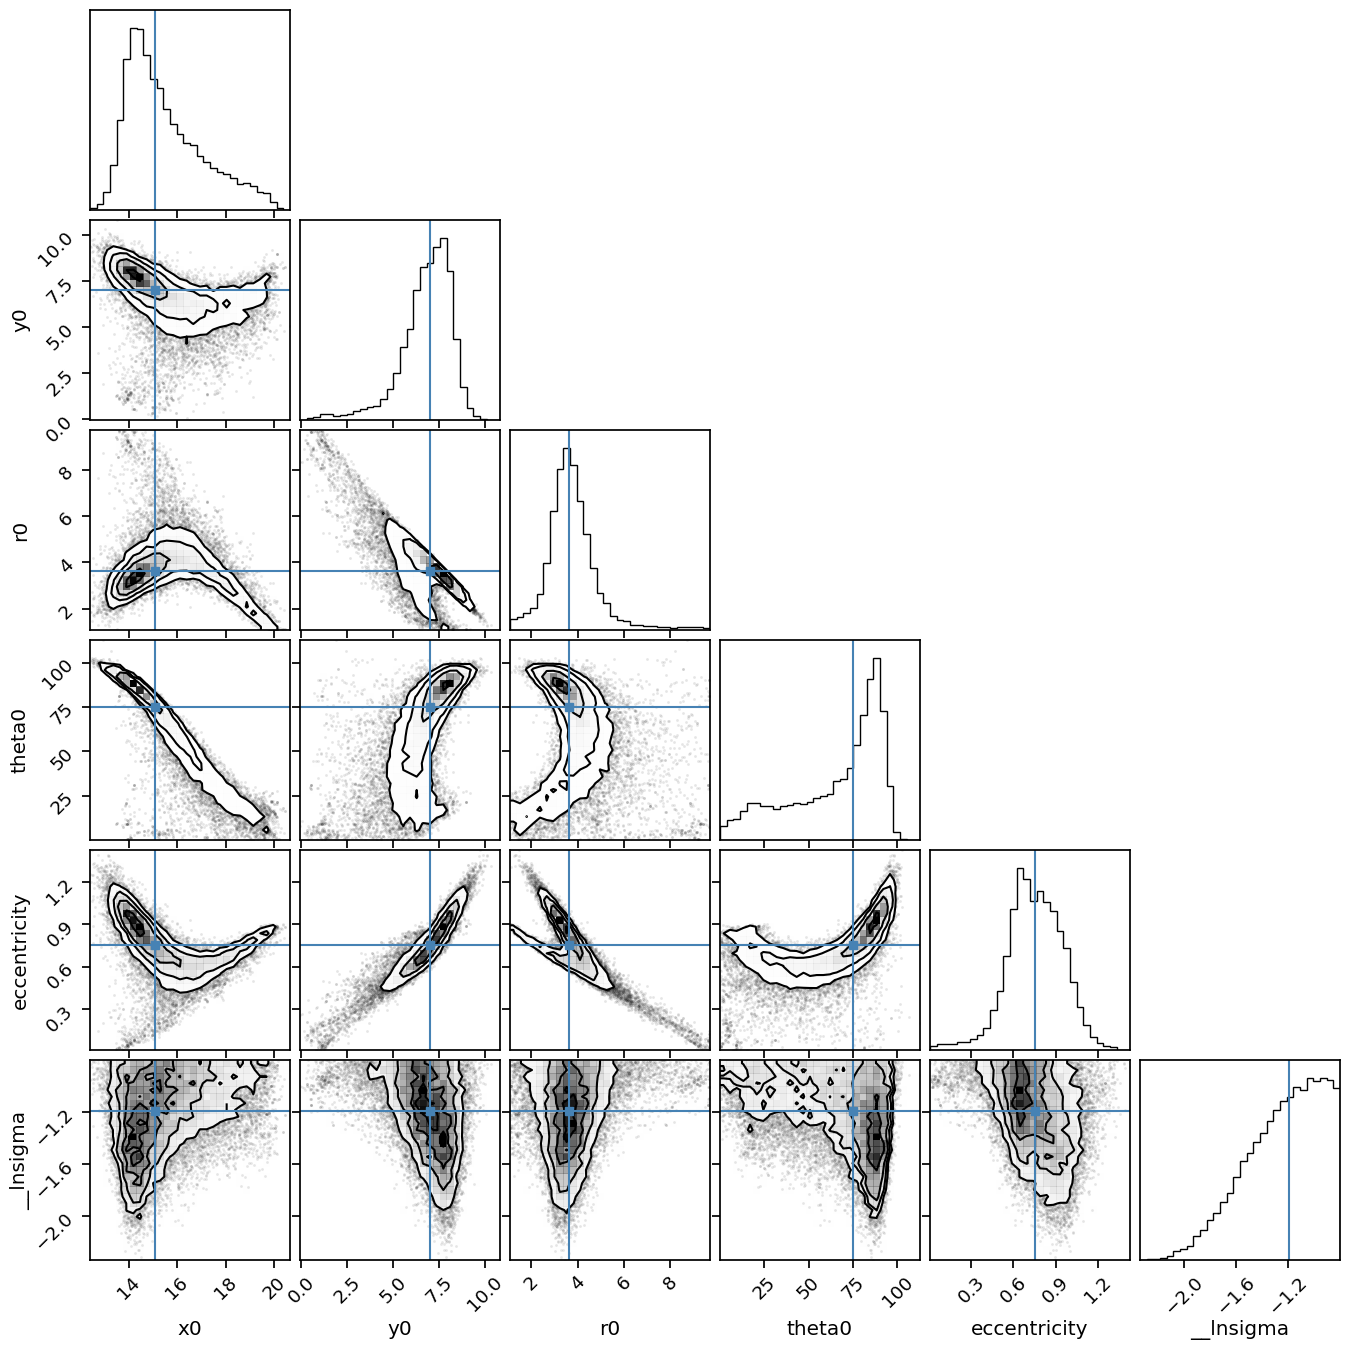

In [42]:
truths = list(result_emcee_ee.params.valuesdict().values())
emcee_plot_ee = corner.corner(
    result_emcee_ee.flatchain,
    labels=result_emcee_ee.var_names,
    truths=truths,
    bins=30,
)

In [43]:
emcee_plot_ee.savefig(
    figpath / f"{saveprefix}-corner-e-improved.pdf", bbox_inches="tight"
)

So this is much better than before, although the contours have some pretty weird shapes. We can see from the bottom row of panels that all the "interesting" behavior is combined to the higher values of `__lnsigma`, so if we could have an independent restriction of the data point uncertainties, then we could eliminate much of the nonsense.

In [44]:
best_xy = confitti.XYconic(**result_e.params.valuesdict())
chain_pars = result_emcee_ee.flatchain.drop(columns="__lnsigma").to_dict(
    orient="records"
)
chain_xy = [confitti.XYconic(**row) for row in chain_pars[7::50]]

/Users/will/Dropbox/confitti/src/confitti/confitti.py:131: RuntimeWarning: divide by zero encountered in divide
  self.r0


Choose a color map for distinguishing the eccentricity

In [45]:
import matplotlib as mpl

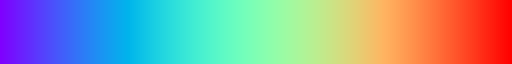

In [46]:
cmap = mpl.cm.rainbow
cmap

Set up a mapping using the $\pm 2 \sigma$ range of eccentricity.

In [47]:
eparam = result_emcee_ee.params["eccentricity"]
emin, emax = eparam.value - 2 * eparam.stderr, eparam.value + 2 * eparam.stderr
norm = mpl.colors.Normalize(vmin=emin, vmax=emax)
norm(1.0)

0.8319367980640004

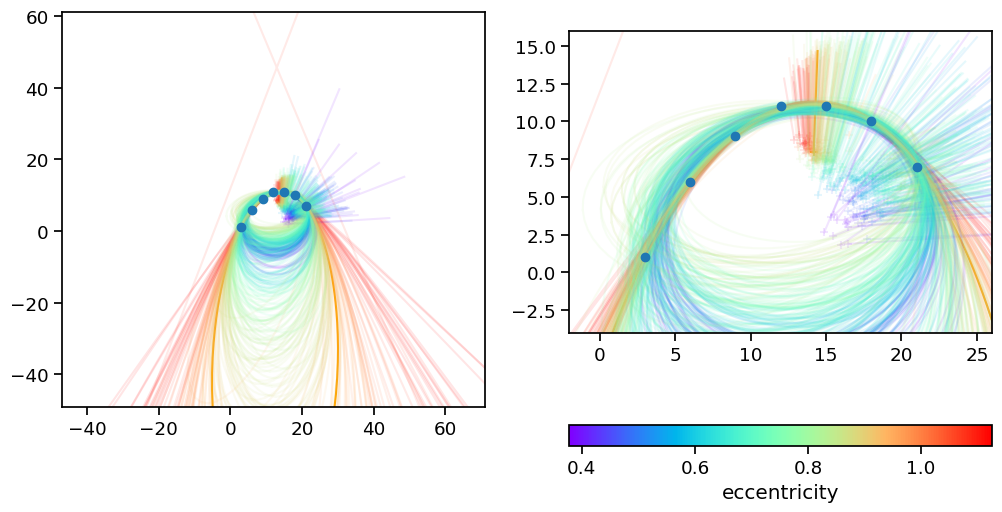

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

for ax in axes:
    c = "orange"
    ax.plot(best_xy.x_pts, best_xy.y_pts, color=c)
    ax.scatter(best_xy.x0, best_xy.y0, marker="+", color=c)
    ax.plot([best_xy.x0, best_xy.x_mirror], [best_xy.y0, best_xy.y_mirror], color=c)

    c = "m"
    alpha = 0.1
    for xy in chain_xy:
        c = cmap(norm(xy.eccentricity))
        ax.plot(xy.x_pts, xy.y_pts, color=c, alpha=alpha)
        ax.scatter(xy.x0, xy.y0, marker="+", color=c, alpha=alpha)
        ax.plot([xy.x0, xy.x_mirror], [xy.y0, xy.y_mirror], color=c, alpha=alpha)
    ax.scatter(xpts, ypts, zorder=1000)
    ax.set_aspect("equal")

margin = 50
axes[0].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
margin = 5
axes[1].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)

fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axes[1],
    orientation="horizontal",
    label="eccentricity",
)
...;

In [49]:
fig.savefig(figpath / f"{saveprefix}-emcee-samples-e-improved.pdf", bbox_inches="tight")

Here we can see that the full range of eccentricities is pretty much filled in. We are rainbow color coding the samples according to the eccentricity from blue (low eccentricity ellipses, $e < 0.5$) through cyan, green, yellow to orange (parabolas, $e = 1$) and red (hyperbolae, $e > 1$).

The samples around $e \approx 1$ have a vertical orientation, whereas the ellipses slew to the right as the eccentricity decreases. Note however that the ellipses with $e < 0.8$ do not fit very well, bulging in front of the points in the near wing. If we had more points in the wings, especially on the right, we could probably eliminate these fits from the running.

## Execution time for notebook

In [50]:
print(f"--- {time.time() - start_time} seconds ---")

--- 130.30177402496338 seconds ---
